## Get Datasets

In [9]:
!unzip 'train.zip'
!unzip 'test.zip'

Archive:  train.zip
   creating: train/
   creating: train/NORMAL/
  inflating: train/NORMAL/IM-0115-0001.jpeg  
  inflating: train/NORMAL/IM-0117-0001.jpeg  
  inflating: train/NORMAL/IM-0119-0001.jpeg  
  inflating: train/NORMAL/IM-0122-0001.jpeg  
  inflating: train/NORMAL/IM-0125-0001.jpeg  
  inflating: train/NORMAL/IM-0127-0001.jpeg  
  inflating: train/NORMAL/IM-0128-0001.jpeg  
  inflating: train/NORMAL/IM-0129-0001.jpeg  
  inflating: train/NORMAL/IM-0131-0001.jpeg  
  inflating: train/NORMAL/IM-0133-0001.jpeg  
  inflating: train/NORMAL/IM-0135-0001.jpeg  
  inflating: train/NORMAL/IM-0137-0001.jpeg  
  inflating: train/NORMAL/IM-0140-0001.jpeg  
  inflating: train/NORMAL/IM-0141-0001.jpeg  
  inflating: train/NORMAL/IM-0143-0001.jpeg  
  inflating: train/NORMAL/IM-0145-0001.jpeg  
  inflating: train/NORMAL/IM-0147-0001.jpeg  
  inflating: train/NORMAL/IM-0149-0001.jpeg  
  inflating: train/NORMAL/IM-0151-0001.jpeg  
  inflating: train/NORMAL/IM-0152-0001.jpeg  
  inflating: 

## 1. Import Libraries & Load Images

In [7]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,  Activation, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras import metrics
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pandas as pd
import math
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Check Devices

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5340742799032762609,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13948360871646467058
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16095181552381771712
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14644711296
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12517971640589681774
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"]

In [10]:
training_path = "train"
test_path = "test"

### 1.1. Normalizing Data

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2,
                                      fill_mode='nearest')  #Divide pixels by 255(where pixel value range from 0-255) and scale them between 0-1
test_datagen = ImageDataGenerator(rescale=1./255)

### 1.2. Generating Images

In [12]:
train_generator = train_datagen.flow_from_directory(training_path, target_size=(150,150), class_mode='binary', classes=['NORMAL', 'PNEUMONIA'])
test_generator = test_datagen.flow_from_directory(test_path, target_size=(150,150), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
train_class = train_generator.classes
test_class = test_generator.classes

## 2. Understanding & Manipulating Data

### 2.1. EDA

### 2.1.1. Distribution of Training & Testing Datasets

In [15]:
from collections import Counter

train_counter = Counter(train_class)
test_counter = Counter(test_class)
print("Training: {}".format(train_counter))
print("Testing: {}".format(test_counter))

Training: Counter({1: 3875, 0: 1341})
Testing: Counter({1: 390, 0: 234})


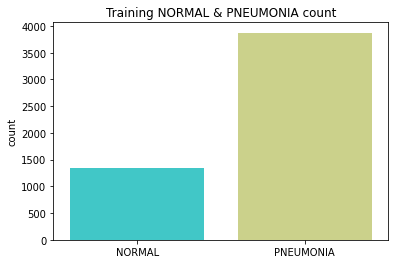

In [16]:
sns.countplot(x=train_class, palette="rainbow")
plt.title("Training NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

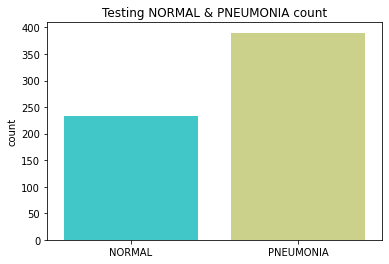

In [17]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Testing NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

### 2.1.2. Viewing Sample Images

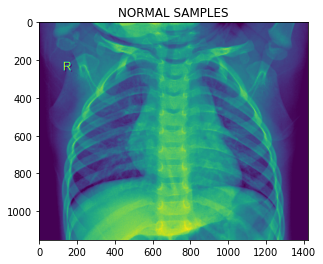

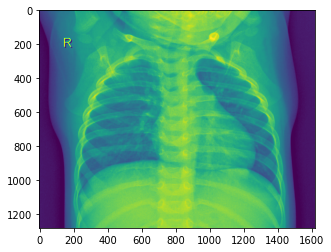

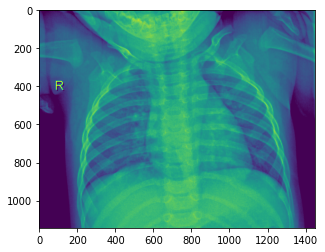

In [18]:
sample_li = [training_path + '/NORMAL/IM-0117-0001.jpeg', training_path + '/NORMAL/IM-0122-0001.jpeg', training_path + '/NORMAL/IM-0131-0001.jpeg']
plt.title("NORMAL SAMPLES")
for i in sample_li:
     img = mpimg.imread(i)
     imgplot = plt.imshow(img)
     plt.show()

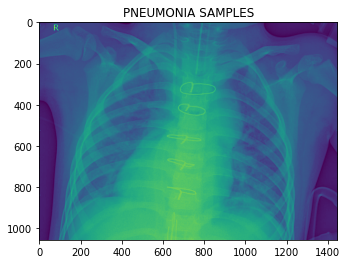

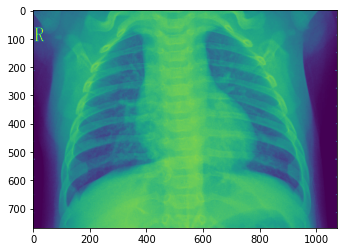

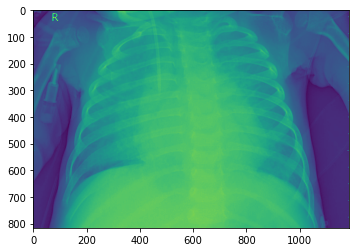

In [19]:
sample_li = [training_path + '/PNEUMONIA/person2_bacteria_3.jpeg', training_path + '/PNEUMONIA/person1000_virus_1681.jpeg', training_path + '/PNEUMONIA/person1004_bacteria_2935.jpeg']
plt.title("PNEUMONIA SAMPLES")
for i in sample_li:
     img = mpimg.imread(i)
     imgplot = plt.imshow(img)
     plt.show()

### 2.2. Generating Weights for handling Imbalanced Data

In [20]:
df = pd.DataFrame({'data':train_generator.classes})
no_pne = int(df[df.data == train_generator.class_indices['NORMAL']].count())
yes_pne = int(df[df.data == train_generator.class_indices['PNEUMONIA']].count())

imb_rat = round(yes_pne / no_pne, 2)

no_weight = imb_rat
yes_weight = 1.0

cweights = {
    train_generator.class_indices['NORMAL']:no_weight,
    train_generator.class_indices['PNEUMONIA']:yes_weight
}

text = "Normal:{:.0f}\nPneumonia:{:.0f}\nImbalance Ratio: {:.2f}\n".format(no_pne, yes_pne, imb_rat)
print(text)
text = "Using class_weights as:\nNormal:{:.2f}\nPneumonia:{:.2f}\n".format(no_weight, yes_weight)
print(text)

Normal:1341
Pneumonia:3875
Imbalance Ratio: 2.89

Using class_weights as:
Normal:2.89
Pneumonia:1.00



### 2.3. Assign input shape based on color channels

In [21]:
img_width, img_height = 150, 150

In [22]:
if k.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

## 3. Model Building

### 3.1. Basic Convolutional Network (CNN)

In [23]:
model = Sequential()
#Feature Extraction
#Block 1
model.add(Conv2D(32,(3,3),input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Classification
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have normal and pneumonia classes

model.summary()

[2022-03-26 19:19:33.310 tensorflow-2-3-gpu--ml-g4dn-xlarge-afdc4952d33ce09f2a7db7721a57:25 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-26 19:19:33.341 tensorflow-2-3-gpu--ml-g4dn-xlarge-afdc4952d33ce09f2a7db7721a57:25 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_______________________

In [25]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
hist = model.fit(train_generator, epochs=25, batch_size=64, class_weight=cweights, validation_data=test_generator, verbose=1)

Epoch 1/25
163/163 [==============================] - 117s 721ms/step - loss: 0.4976 - accuracy: 0.8416 - precision_1: 0.9751 - recall: 0.8075 - val_loss: 2.0442 - val_accuracy: 0.6250 - val_precision_1: 0.6250 - val_recall: 1.0000
Epoch 2/25
163/163 [==============================] - 80s 491ms/step - loss: 0.3692 - accuracy: 0.8928 - precision_1: 0.9778 - recall: 0.8756 - val_loss: 1.6706 - val_accuracy: 0.5481 - val_precision_1: 0.9737 - val_recall: 0.2846
Epoch 3/25
163/163 [==============================] - 80s 492ms/step - loss: 0.2909 - accuracy: 0.9158 - precision_1: 0.9804 - recall: 0.9048 - val_loss: 3.6964 - val_accuracy: 0.6298 - val_precision_1: 0.6280 - val_recall: 1.0000
Epoch 4/25
163/163 [==============================] - 80s 493ms/step - loss: 0.3015 - accuracy: 0.9185 - precision_1: 0.9778 - recall: 0.9110 - val_loss: 0.6112 - val_accuracy: 0.7933 - val_precision_1: 0.8000 - val_recall: 0.8923
Epoch 5/25
163/163 [==============================] - 80s 491ms/step - loss

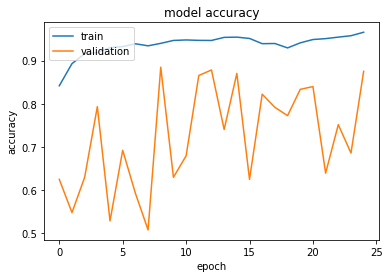

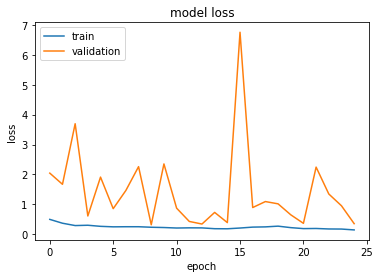

In [26]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 3.2. VGG16

In [27]:
num_of_classes = 2
batch_size = 32

base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
    
for layer in base_model.layers:
    if layer.name != 'block5_conv3':
        layer.trainable = False
    else:
        layer.trainable = True

x = base_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(x) #Pooling + Flatten
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______________________________________________________

In [28]:
optSGD = optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model1.compile(loss='binary_crossentropy', optimizer=optSGD, metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [31]:
hist_vgg = model1.fit(train_generator,
                    validation_data=test_generator,
                    class_weight=cweights,
                    epochs=70, verbose=1)

Epoch 1/70
163/163 [==============================] - 79s 487ms/step - loss: 0.8368 - accuracy: 0.7019 - precision_2: 0.8833 - recall_1: 0.6898 - val_loss: 0.4623 - val_accuracy: 0.8381 - val_precision_2: 0.9502 - val_recall_1: 0.7821
Epoch 2/70
163/163 [==============================] - 79s 483ms/step - loss: 0.5450 - accuracy: 0.8480 - precision_2: 0.9485 - recall_1: 0.8410 - val_loss: 0.3747 - val_accuracy: 0.8606 - val_precision_2: 0.9522 - val_recall_1: 0.8179
Epoch 3/70
163/163 [==============================] - 80s 489ms/step - loss: 0.4192 - accuracy: 0.8859 - precision_2: 0.9667 - recall_1: 0.8766 - val_loss: 0.3345 - val_accuracy: 0.8686 - val_precision_2: 0.9425 - val_recall_1: 0.8410
Epoch 4/70
163/163 [==============================] - 80s 492ms/step - loss: 0.3648 - accuracy: 0.8990 - precision_2: 0.9715 - recall_1: 0.8901 - val_loss: 0.2908 - val_accuracy: 0.8910 - val_precision_2: 0.9045 - val_recall_1: 0.9231
Epoch 5/70
163/163 [==============================] - 81s 49

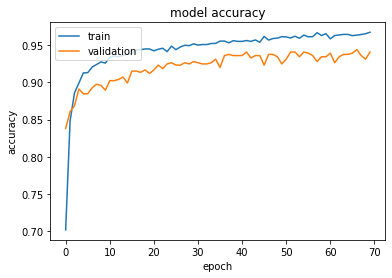

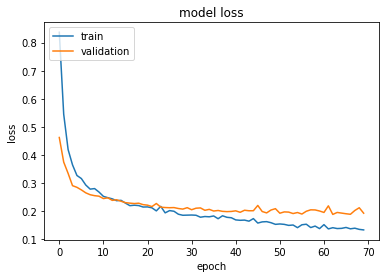

In [32]:
# "Accuracy"
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 3.3. RESTNET50

In [33]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_model.layers:
    layer.trainable = False
    
x = Flatten()(resnet_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=resnet_model.input, outputs=x)
model2.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________

In [35]:
model2.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy', metrics.Precision(), metrics.Recall()])

hist_rest = model2.fit(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 38s 230ms/step - loss: 0.3340 - accuracy: 0.9061 - precision_3: 0.9697 - recall_2: 0.9017 - val_loss: 0.2904 - val_accuracy: 0.8798 - val_precision_3: 0.9339 - val_recall_2: 0.8692
Epoch 2/70
163/163 [==============================] - 37s 224ms/step - loss: 0.3229 - accuracy: 0.9082 - precision_3: 0.9732 - recall_2: 0.9012 - val_loss: 0.3136 - val_accuracy: 0.8782 - val_precision_3: 0.8552 - val_recall_2: 0.9692
Epoch 3/70
163/163 [==============================] - 37s 225ms/step - loss: 0.3286 - accuracy: 0.9057 - precision_3: 0.9737 - recall_2: 0.8973 - val_loss: 0.2917 - val_accuracy: 0.8862 - val_precision_3: 0.8735 - val_recall_2: 0.9564
Epoch 4/70
163/163 [==============================] - 37s 226ms/step - loss: 0.3180 - accuracy: 0.9135 - precision_3: 0.9724 - recall_2: 0.9094 - val_loss: 0.2744 - val_accuracy: 0.8910 - val_precision_3: 0.8852 - val_recall_2: 0.9487
Epoch 5/70
163/163 [==============================] - 37s 22

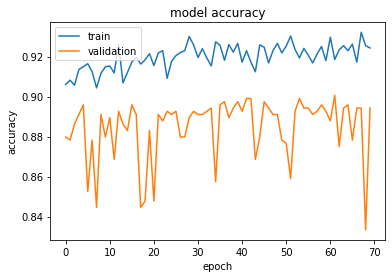

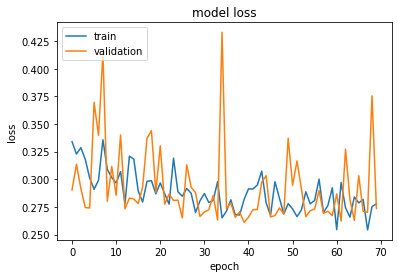

In [36]:
# "Accuracy"
plt.plot(hist_rest.history['accuracy'])
plt.plot(hist_rest.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_rest.history['loss'])
plt.plot(hist_rest.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 3.4. InceptionV3

In [37]:
base_model = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=output)
model3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_4[0][0]      
______________________

In [38]:
opt = optimizers.Adam(learning_rate=0.0003)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', metrics.Precision(), metrics.Recall()])

hist_incep = model3.fit(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 38s 232ms/step - loss: 0.4166 - accuracy: 0.8689 - precision_4: 0.9747 - recall_3: 0.8454 - val_loss: 0.3031 - val_accuracy: 0.8782 - val_precision_4: 0.8601 - val_recall_3: 0.9615
Epoch 2/70
163/163 [==============================] - 37s 224ms/step - loss: 0.3093 - accuracy: 0.9147 - precision_4: 0.9761 - recall_3: 0.9074 - val_loss: 0.2992 - val_accuracy: 0.8782 - val_precision_4: 0.8965 - val_recall_3: 0.9103
Epoch 3/70
163/163 [==============================] - 36s 223ms/step - loss: 0.2740 - accuracy: 0.9283 - precision_4: 0.9789 - recall_3: 0.9234 - val_loss: 0.3141 - val_accuracy: 0.8670 - val_precision_4: 0.8404 - val_recall_3: 0.9718
Epoch 4/70
163/163 [==============================] - 36s 222ms/step - loss: 0.2811 - accuracy: 0.9235 - precision_4: 0.9777 - recall_3: 0.9179 - val_loss: 0.3042 - val_accuracy: 0.8782 - val_precision_4: 0.8536 - val_recall_3: 0.9718
Epoch 5/70
163/163 [==============================] - 36s 22

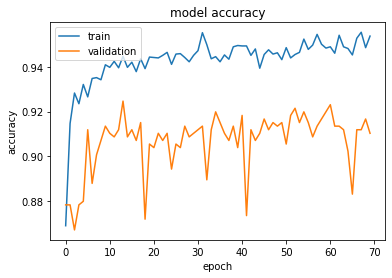

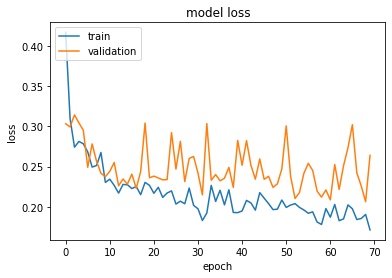

In [40]:
# "Accuracy"
plt.plot(hist_incep.history['accuracy'])
plt.plot(hist_incep.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_incep.history['loss'])
plt.plot(hist_incep.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Making Predictions

### 4.1. Basic Convolutional Neural Network (CNN)

In [46]:
result_tabulation = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

pred_cnn = model.evaluate(test_generator)
CNN = pd.Series({"Model": "Basic CNN", "Loss": pred_cnn[0], "Accuracy": pred_cnn[1], "Precision": pred_cnn[2], "Recall": pred_cnn[3]})
result_tabulation = result_tabulation.append(CNN, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 272ms/step - loss: 0.3543 - accuracy: 0.8750 - precision_1: 0.9588 - recall: 0.8359


,Model,Loss,Accuracy,Precision,Recall
0,Basic CNN,0.354318,0.875,0.958824,0.835897


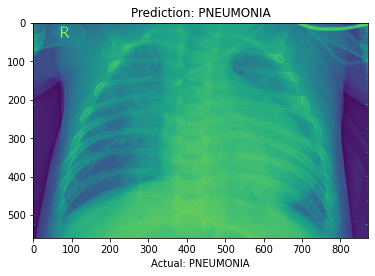

In [60]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

result = model.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

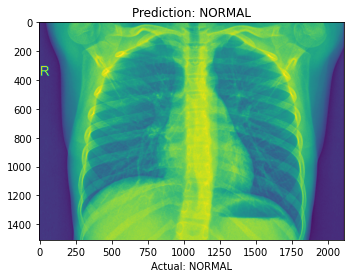

In [61]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

### 4.2. VGG16

In [48]:
pred_vgg = model1.evaluate(test_generator)
VGG =  pd.Series({"Model": "VGG16", "Loss": pred_vgg[0], "Accuracy": pred_vgg[1], "Precision": pred_vgg[2], "Recall": pred_vgg[3]})
result_tabulation = result_tabulation.append(VGG, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 263ms/step - loss: 0.1929 - accuracy: 0.9407 - precision_2: 0.9315 - recall_1: 0.9769


,Model,Loss,Accuracy,Precision,Recall
0,Basic CNN,0.354318,0.875000,0.958824,0.835897
1,VGG16,0.192875,0.940705,0.931540,0.976923


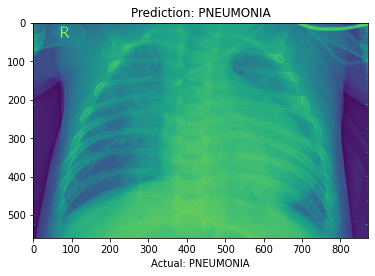

In [62]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model1.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

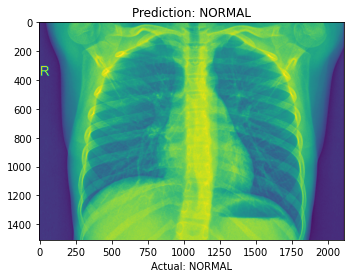

In [63]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model1.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

### 4.3. RESTNET50

In [50]:
pred_rest = model2.evaluate(test_generator)
RESTNET =  pd.Series({"Model": "RESTNET50", "Loss": pred_rest[0], "Accuracy": pred_rest[1], "Precision": pred_rest[2], "Recall": pred_rest[3]})
result_tabulation = result_tabulation.append(RESTNET, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 272ms/step - loss: 0.2736 - accuracy: 0.8942 - precision_3: 0.9219 - recall_2: 0.9077


,Model,Loss,Accuracy,Precision,Recall
0,Basic CNN,0.354318,0.875000,0.958824,0.835897
1,VGG16,0.192875,0.940705,0.931540,0.976923
2,RESTNET50,0.273555,0.894231,0.921875,0.907692


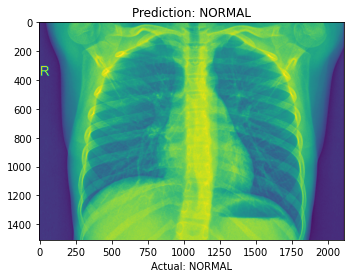

In [64]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model2.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

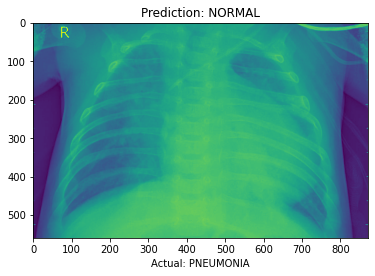

In [65]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model2.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

### 4.4. InceptionV3

In [52]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

20/20 [==============================] - 5s 266ms/step - loss: 0.2639 - accuracy: 0.9103 - precision_4: 0.8976 - recall_3: 0.9667


,Model,Loss,Accuracy,Precision,Recall
0,Basic CNN,0.354318,0.875000,0.958824,0.835897
1,VGG16,0.192875,0.940705,0.931540,0.976923
2,RESTNET50,0.273555,0.894231,0.921875,0.907692
3,InceptionV3,0.263877,0.910256,0.897619,0.966667


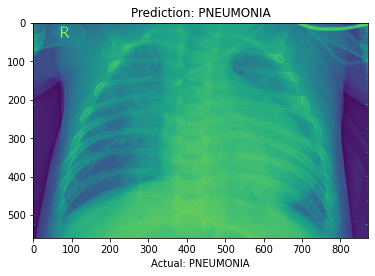

In [66]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

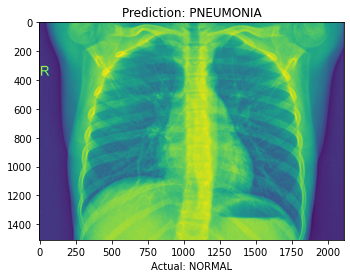

In [67]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "Prediction: PNEUMONIA"
else:
    prediction = "Prediction: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

## 5. Conclusion

In [54]:
result_tabulation

,Model,Loss,Accuracy,Precision,Recall
0,Basic CNN,0.354318,0.875000,0.958824,0.835897
1,VGG16,0.192875,0.940705,0.931540,0.976923
2,RESTNET50,0.273555,0.894231,0.921875,0.907692
3,InceptionV3,0.263877,0.910256,0.897619,0.966667


#### From the above results, we can conclude that VGG16 is much more stable and better performing model as compared to Basic Convolutional Neural Network (CNN), RestNet50, InceptionV3 models. Hence, VGG16 is the preferred model for the prediction of Pneumonia patients.